In [27]:
import pandas as pd
import easygui as eg
import numpy as np
import seaborn as sns
import matplotlib as plt
from scipy.optimize import curve_fit

In [29]:
data_file = 'LDF74_Run_Results.txt'
#data_file = eg.fileopenbox(filetypes=['txt','csv'],msg='Select Data File to load')

In [28]:
header= {0:'Chamber',1:'Subject',2:'Session',
         3:'Channel',4:'Trial',5:'Trial Num',
         6:'Group',7:'Param',8:'Trial List Block',
         9:'Samples',10:'Rate',11:'V Start',12:'mV Max',
         13:'T Max',14:'mv Avg',15:'V Peak',16:'T Peak',
         17:'Run Time',18:'TimeStamp',19:'Run Data'}

In [30]:
data = pd.read_csv(data_file,header=None)
data = data.rename(columns=header)
data = data.drop(columns=['Param','Run Data'])
data = data.dropna()

In [31]:
# Parse Session and Trial into Date, Animal, Session_Type, Trial_Type, Stim DB, Prepulse DB
data = pd.concat((data,data.Session.str.split('_', expand=True)), axis=1).rename(columns={0:'Date',1:'Animal',2:'Session_Type'})
data = pd.concat((data,data.Trial.str.split('_',expand=True)),axis=1).rename(columns={0:'Trial_Type',1:'Stim_dB',2:'Prepulse_dB'})
cols = ['Stim_dB','Prepulse_dB']
data[cols] = data[cols].apply(pd.to_numeric)
animal = data['Subject'].unique()[0]
#data.head()

In [32]:
# Grab ASR data 
asrData = data.query('Session_Type=="ASR"')

In [34]:
def logfunc(x,a,b):
    #y = a/(1+np.exp(-b*(x-c)))
    y = a+b*np.log(x)
    return y

In [36]:
def calcPPI(row):
   # print(row)
    if row['Trial_Type']=='PPI':
        stimDB = row['Stim_dB']
        stimMean = ppiData.query('Trial_Type=="Startle" & Stim_dB==@stimDB')['mV Max'].mean()
        return 100*(1-row['mV Max']/stimMean)
    else:
        return row['% PPI']

In [48]:
def ppi_mets(x):
    d = {}
    d['Mean Startle (mV)'] = x['mV Max'].mean()
    d['Startle SD (mV)'] = x['mV Max'].std()
    d['Mean PPI (%)'] = x['% PPI'].mean()
    d['PPI SD (%)'] = x['% PPI'].std()
    return pd.Series(d,index=['Mean Startle (mV)','Startle SD (mV)','Mean PPI (%)','PPI SD (%)'])
ppi_metrics = ppiData.groupby(['Trial_Type','Stim_dB','Prepulse_dB']).apply(ppi_mets).round(2)

In [33]:
custom_style = {'figure.facecolor':'.8',
                "axes.facecolor":".8",
                'axes.edgecolor':'.8',
                "axes.labelcolor":"black",
                "axes.grid":True,
                'grid.color':'black',
                "text.color":"black",
                "patch_edgecolor":'black',
                "xtick.color":"black",
                "ytick.color":"black",
                'axes.edgecolor':'black'}
sns.set_style('whitegrid',rc=custom_style)
sns.set_context('talk')
col_palette = sns.color_palette("bright")

In [35]:
ppiData = data.query('Session_Type=="rPPI"')

In [37]:
startleDB = ppiData.query('Trial_Type=="Startle"')['Stim_dB'].unique()
ppiData["% PPI"] = np.nan
ppiData['% PPI'] = ppiData.apply(calcPPI,axis=1)

/home/roshan/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/roshan/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/home/roshan/.local/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


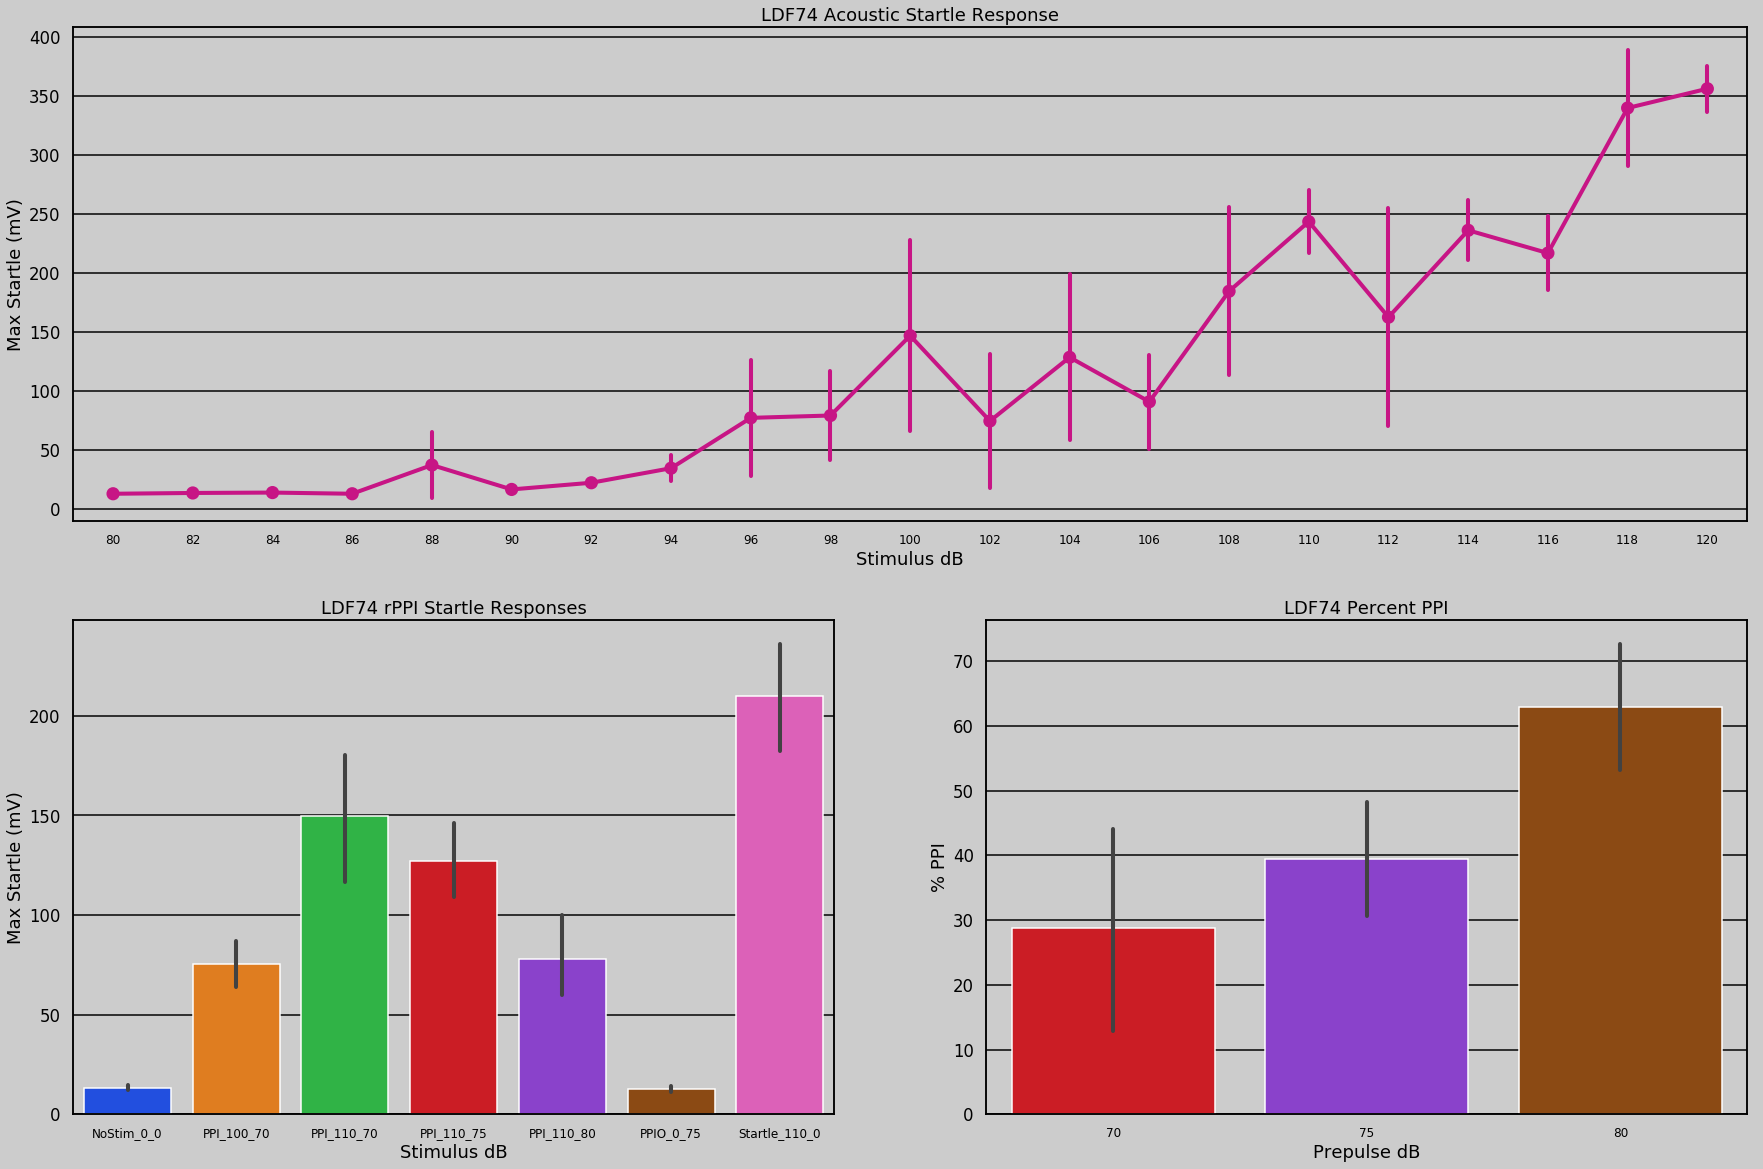

In [38]:
pal = sns.color_palette('bright')
plt.rcParams["figure.figsize"] = (30, 20)
plt.rcParams["xtick.labelsize"] = 12
ax = plt.pyplot.subplot(2,1,1)
g = sns.pointplot(ax=ax,x="Stim_dB",y='mV Max',data=asrData,color='mediumvioletred',ci='sd')
g.set_title(animal+' Acoustic Startle Response')
g.set(xlabel='Stimulus dB',ylabel='Max Startle (mV)')

ax = plt.pyplot.subplot(2,2,3)
g = sns.barplot(ax=ax,x='Trial',y='mV Max',data=ppiData,palette='bright')
g.set_title(animal+' rPPI Startle Responses')
g.set(xlabel='Stimulus dB',ylabel='Max Startle (mV)')

ax=plt.pyplot.subplot(2,2,4)
g=sns.barplot(ax = ax,x='Prepulse_dB',y="% PPI",data=ppiData,order = [70,75,80],palette=pal[3:6])
g.set_title(animal+' Percent PPI')
g.set(xlabel='Prepulse dB',ylabel='% PPI')

plt.pyplot.savefig(animal+'_PPI_Results_Figure.png')

In [39]:
ppiData.groupby('Trial').count()

,Chamber,Subject,Session,Channel,Trial Num,Group,Trial List Block,Samples,Rate,V Start,...,T Peak,Run Time,TimeStamp,Date,Animal,Session_Type,Trial_Type,Stim_dB,Prepulse_dB,% PPI
Trial,,,,,,,,,,,,,,,,,,,,,
NoStim_0_0,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,0
PPIO_0_75,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,0
PPI_100_70,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,0
PPI_110_70,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
PPI_110_75,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
PPI_110_80,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
Startle_110_0,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,0


In [40]:
# Also make & output table of trial counts for each session
# Validate animal names
# Check how many nans are dropped

In [41]:
a = data.groupby(['Session_Type','Trial_Type','Stim_dB','Prepulse_dB']).size()#.reset_index(name='counts')
print(a)

Session_Type  Trial_Type  Stim_dB  Prepulse_dB
ACC           NoStim      0        0               5
ACC2          NoStim      0        0               4
ASR           Startle     80       0               3
                          82       0               3
                          84       0               3
                          86       0               3
                          88       0               3
                          90       0               3
                          92       0               3
                          94       0               3
                          96       0               3
                          98       0               3
                          100      0               3
                          102      0               3
                          104      0               3
                          106      0               3
                          108      0               3
                          110      0               3

In [43]:
print('Loaded data for '+animal+'\n\nTrial Counts\n---------------')
print(a.to_frame().rename(columns={0:'Counts'}))

Loaded data for LDF74

Trial Counts
---------------
                                             Counts
Session_Type Trial_Type Stim_dB Prepulse_dB        
ACC          NoStim     0       0                 5
ACC2         NoStim     0       0                 4
ASR          Startle    80      0                 3
                        82      0                 3
                        84      0                 3
                        86      0                 3
                        88      0                 3
                        90      0                 3
                        92      0                 3
                        94      0                 3
                        96      0                 3
                        98      0                 3
                        100     0                 3
                        102     0                 3
                        104     0                 3
                        106     0                 3
            

In [51]:
#ppi_metrics = ppi_metrics.to_frame()
print ('\n\nPPI Metrics\n------------\n')
print(ppi_metrics)



PPI Metrics
------------

                                Mean Startle (mV)  Startle SD (mV)  \
Trial_Type Stim_dB Prepulse_dB                                       
NoStim     0       0                        13.42             2.07   
PPI        100     70                       75.50            16.26   
           110     70                      149.64            59.17   
                   75                      127.27            33.13   
                   80                       77.92            38.29   
PPIO       0       75                       12.67             2.61   
Startle    110     0                       210.06            58.23   

                                Mean PPI (%)  PPI SD (%)  
Trial_Type Stim_dB Prepulse_dB                            
NoStim     0       0                     NaN         NaN  
PPI        100     70                    NaN         NaN  
           110     70                  28.77       28.17  
                   75                  39.41  